## Setup

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
from itertools import count
import pandas as pd
import gymnasium as gym

from IPython import display

import stockcore.data as scdata
import stockcore.models as scmodels
import stockcore.environment as scenv
import stockcore.utils as scutils

In [2]:
is_ipython = scutils.setup_mpl()
device = scutils.get_device()

if is_ipython:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

### Data

In [3]:
# read csv as pandas dataframe
btc_usd_df = pd.read_csv('btc_usd.csv')
eth_usd_df = pd.read_csv('eth_usd.csv')
print(btc_usd_df.shape)
print(eth_usd_df.shape)
print(btc_usd_df.head(5))
print(eth_usd_df.head(5))

(37305, 7)
(37305, 7)
                  date           unix     open     high      low    close  \
0  2020-08-18 07:00:00  1597734000000  12278.7  12289.3  12246.5  12284.4   
1  2020-08-18 08:00:00  1597737600000  12283.5  12306.1  12265.5  12265.8   
2  2020-08-18 09:00:00  1597741200000  12265.0  12273.9  12231.3  12235.2   
3  2020-08-18 10:00:00  1597744800000  12234.8  12313.2  12197.9  12295.4   
4  2020-08-18 11:00:00  1597748400000  12293.7  12298.8  12180.4  12189.4   

       volume  
0  167.048618  
1  148.145490  
2  155.735895  
3  206.575700  
4  210.599326  
                  date           unix    open    high     low   close  \
0  2020-08-18 07:00:00  1597734000000  430.00  435.00  410.00  430.30   
1  2020-08-18 08:00:00  1597737600000  430.27  431.79  430.27  430.80   
2  2020-08-18 09:00:00  1597741200000  430.86  431.13  428.71  429.35   
3  2020-08-18 10:00:00  1597744800000  429.75  432.69  428.59  431.90   
4  2020-08-18 11:00:00  1597748400000  432.09  432.89 

### Environment

In [4]:
env = scenv.MultiStockTradingEnv(name= "BTC_ETH_USD", dfs=[btc_usd_df, eth_usd_df], trading_fees=0.01/100)

## Baseline: Random Agent

In [5]:
# Eatch step, the environment will return 5 inputs  : "feature_close", "feature_open", "feature_high", "feature_low", "feature_volume"
# Run an episode until it ends :
done, truncated = False, False
observation = env.reset()
# pbar = tqdm(total=env.get_dfs_length())
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    # pbar.update(1)
    observation, reward, done, truncated, info = env.step(position_index)

Portfolio Return : -88.56%


## Agent: Q-Learning

### Build Agent

In [6]:
BATCH_SIZE = 128  # number of transitions sampled from the replay buffer
GAMMA = 0.99  # discount factor
EPS_START = 0.9  # starting value of epsilon
EPS_END = 0.05  # final value of epsilon
EPS_DECAY = 1000  # rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005  # update rate of the target network
LR = 1e-4  # learning rate of the `AdamW` optimizer
MEMORY_SIZE = 10000  # size of the replay buffer

In [7]:
n_actions: int = env.action_space.n  # Get number of actions from gym action space
state = env.reset()  # Get the number of state observations
n_observations = len(state)

policy_net = scmodels.NaiveDQN(env).to(device)
target_net = scmodels.NaiveDQN(env).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = scenv.ReplayMemory(MEMORY_SIZE)

### Visualization

In [8]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = scenv.Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    foo = policy_net(state_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(
            non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,
                     expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [10]:
if scutils.is_backend_available():
    num_episodes = 10
else:
    num_episodes = 60

In [ ]:
def select_action(state: torch.Tensor) -> torch.Tensor:
    select_action.steps_done = getattr(select_action, 'steps_done', 0)

    eps_threshold = EPS_END + (
        (EPS_START - EPS_END) *
        math.exp(-1. * select_action.steps_done / EPS_DECAY)
    )
    
    select_action.steps_done += 1

    return policy_net.act(state, eps_threshold)

Complete


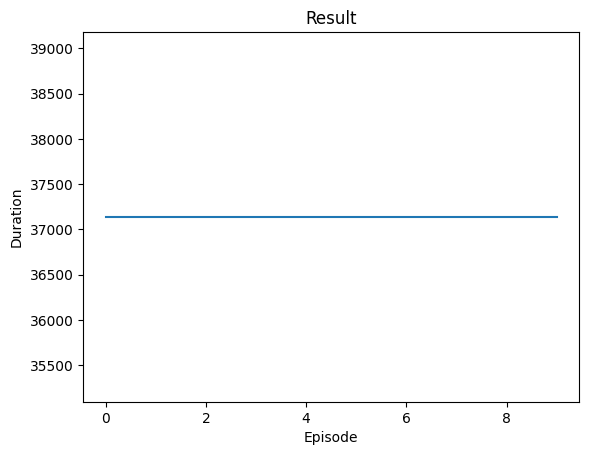

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
for i_episode in (pbar_epoch := tqdm(range(num_episodes))):
    # Initialize the environment and get its state
    state = env.reset()
    state = torch.tensor(
        state,
        dtype=torch.float32, device=device).unsqueeze(0)
    for t in (pbar_step := tqdm(count(), leave=False, total=env.get_dfs_length())):
        action = select_action(state).to(device)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = (
                policy_net_state_dict[key] * TAU +
                target_net_state_dict[key] * (1 - TAU))
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [14]:
# Save the model
torch.save(policy_net.state_dict(), 'model.pth')